<a href="https://colab.research.google.com/github/jean-on-hub/Image-Captioning/blob/model_building/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Necessary libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

###Import the data

Coco dataset import

Annotations

In [3]:

annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)


252887040/252872794 [==============================] - 6s 0us/step


In [6]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

###Images

In [4]:
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510582272/13510573713 [==============================] - 285s 0us/step


In [7]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + '/COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

List of images paths

In [8]:
image_paths = list(image_path_to_caption.keys())

captions and vector list

In [9]:
train_captions = []
img_name_vector = []

for image_path in image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

Data Example

<start> A stop sign that has been vandalized is pictured in front of a parked car. <end>


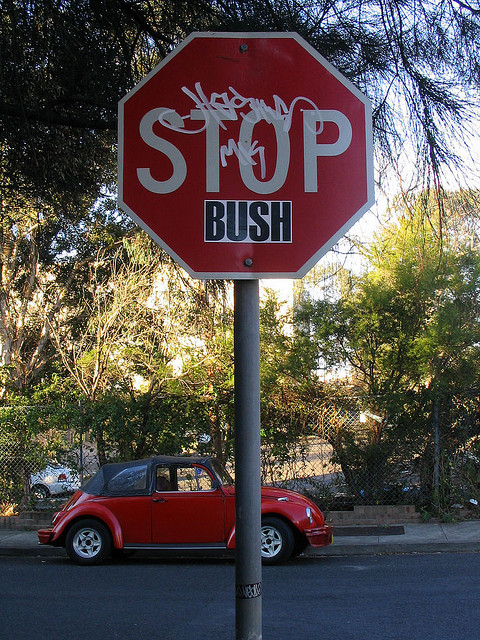

In [10]:
print(train_captions[13])

Image.open(img_name_vector[11])

### Create train and evaluation dataset

In [24]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/',class_names =None,labels= None,
  validation_split=0.2,
  subset="training",
  seed=123,
  
  batch_size=32)

Found 82783 files belonging to 1 classes.
Using 66227 files for training.


In [26]:
train_ds

<BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>

In [27]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/',
  validation_split=0.2,
  subset="validation",
  seed=123,
  batch_size=32)

Found 82783 files belonging to 4 classes.
Using 16556 files for validation.
